# Librerías

In [1]:
import pandas as pd
from palette_creator import PaletteCreator, show_palette, bit_cut, bit_amplify, gaussian_filter
from pathlib import Path
import cv2
import json

# Funciones auxiliares

In [2]:
import numpy as np

def load_img(path_img):
    path_img = str(path_img)

    # Check if path exists
    if not Path(path_img).exists():
        print(f"Path {path_img} doesn't exist")
        return None
    
    return cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2RGB)

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def save_results_to_db(db, method, palettes, proportions): 
    db[f"{method}_palette"], db[f"{method}_proportions"] = palettes, proportions
    db[f"{method}_palette"] = db[f"{method}_palette"].apply(lambda x: json.dumps(x, cls=NumpyEncoder))
    db[f"{method}_proportions"] = db[f"{method}_proportions"].apply(lambda x: json.dumps(x, cls=NumpyEncoder))


# Configuración

In [3]:
# establecer rutas
PATH_IMAGES_FOLDER = Path('data/beatriz_gonzalez')
PATH_IMAGES_METADATA = Path("beatriz_gonzalez.csv")

db = pd.read_csv(PATH_IMAGES_METADATA)
db["path_image"] = PATH_IMAGES_FOLDER/db["filename"]

# Preprocesamiento

1. Cargar imágenes
2. Aplicar filtros o técnicas de preprocesamiento (o combinaciones)
    - Filtro gaussiano
    - Bit-cutting

In [4]:
%%time
# toca hacer resize ya que el modelo solo acepta imagenes 512x512x3
images = [cv2.resize(bit_cut(load_img(path_image))/32, (512,512)) for path_image in db["path_image"]] # cargar imagenes en una lista

CPU times: user 1min 53s, sys: 1min 13s, total: 3min 6s
Wall time: 1min 34s


In [5]:
# aplicar bit-cutting removiendo 4 bits (k=4)
#preprocessed_images = [bit_cut(image, k=3) for image in images]

# aplicar filtro gaussiano
# preprocessed_images = [gaussian_filter(image) for image in images]

#aplicar ambos
#preprocessed_images = [bit_cut(gaussian_filter(image), k=4) for image in images]


# Usando exclusivamente el modelo preentrenado

In [5]:
pc = PaletteCreator(method="neural_network")

In [6]:
%%time
palettes, proportions = pc.create_palette(images) # crear paletas

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1238/1238 [04:56<00:00,  4.17it/s]

CPU times: user 5min 39s, sys: 8.41 s, total: 5min 47s
Wall time: 4min 56s


## Guardar resultados

In [7]:
save_results_to_db(db, "neuralnetwork+bitcutting", palettes, proportions)
db.to_csv(PATH_IMAGES_METADATA, index=False)

# Ejemplo de visualización

In [36]:
#db = pd.read_csv(PATH_IMAGES_METADATA)

In [37]:
#palette_img = db['kmeans_palette'].values
#proportions_img = db['kmeans_proportions'].values

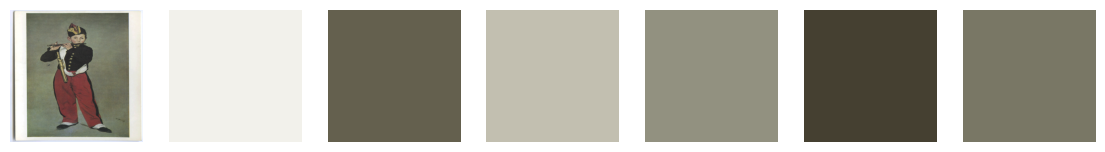

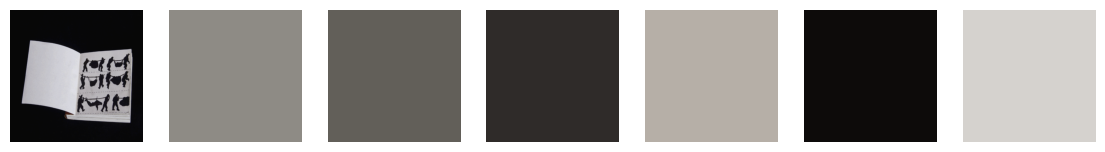

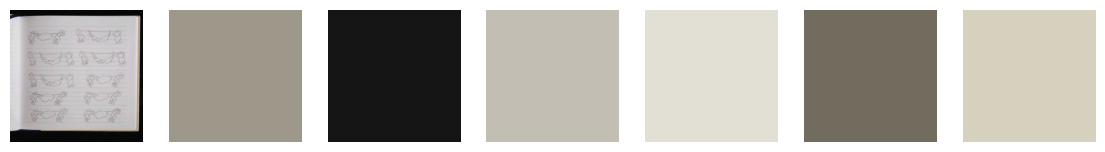

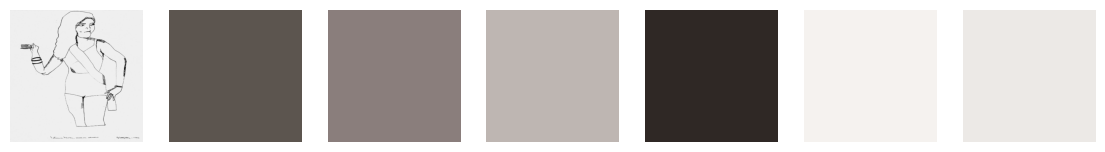

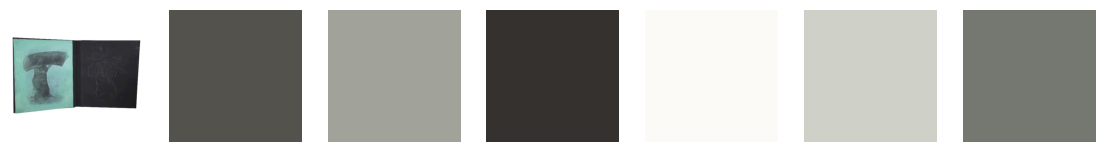

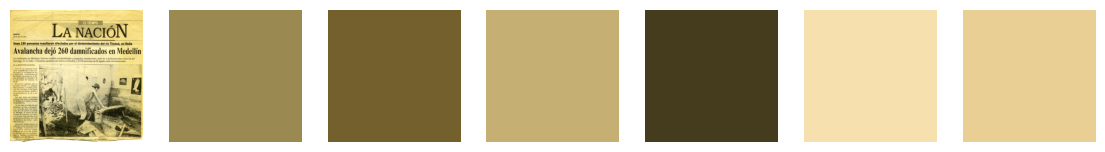

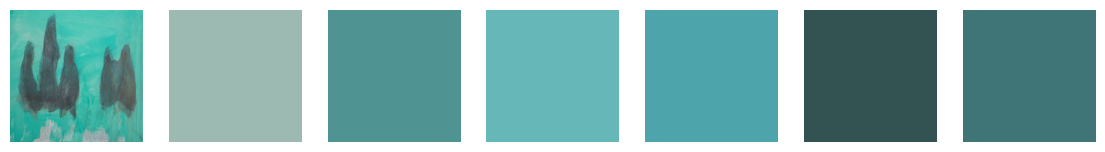

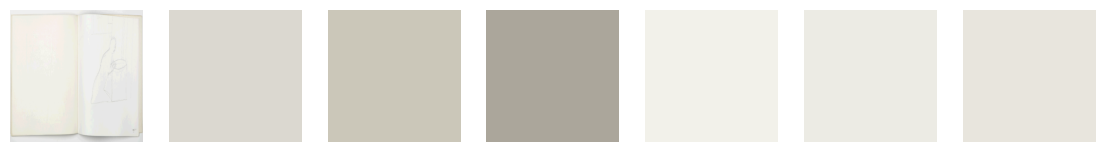

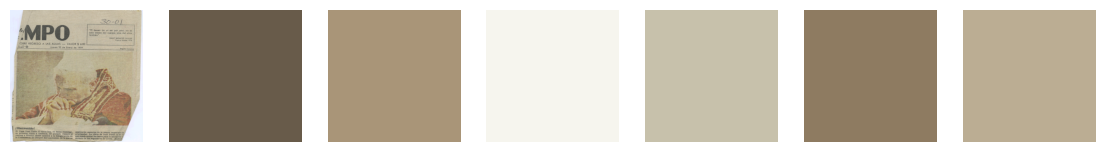

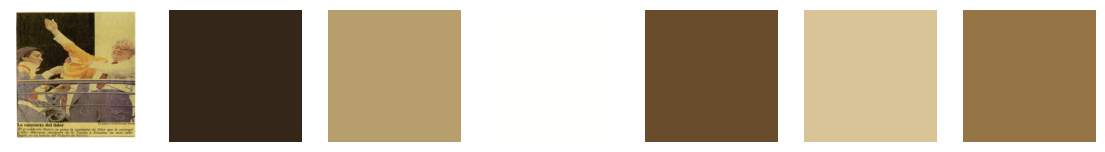

In [8]:
for i, image in enumerate(images[:10]):
    if image is not None:
        img_palette = palettes[i]
        show_palette(img_palette, img=image)

# Entrenando el modelo desde el modelo preentrenado

In [9]:
pc = PaletteCreator(method="neural_network", train_epochs=20, train_images = np.array(images))

Epoch 20/20: 100%|██████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  8.19batch/s, loss=0.0013]


In [10]:
%%time
palettes, proportions = pc.create_palette(images) # crear paletas

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1238/1238 [04:55<00:00,  4.18it/s]

CPU times: user 5min 44s, sys: 8.08 s, total: 5min 53s
Wall time: 4min 55s


## Guardar resultados

In [11]:
save_results_to_db(db, "neuralnetwork+train+bitcutting", palettes, proportions)
db.to_csv(PATH_IMAGES_METADATA, index=False)

# Ejemplo de visualización

In [12]:
#db = pd.read_csv(PATH_IMAGES_METADATA)

In [13]:
#palette_img = db['kmeans_palette'].values
#proportions_img = db['kmeans_proportions'].values

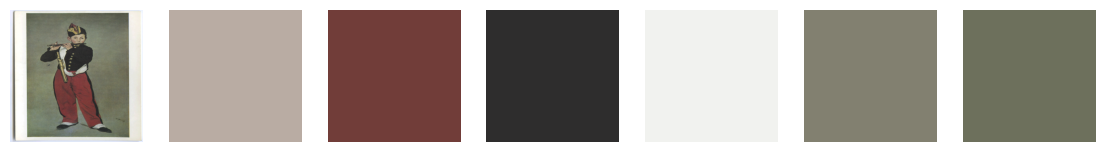

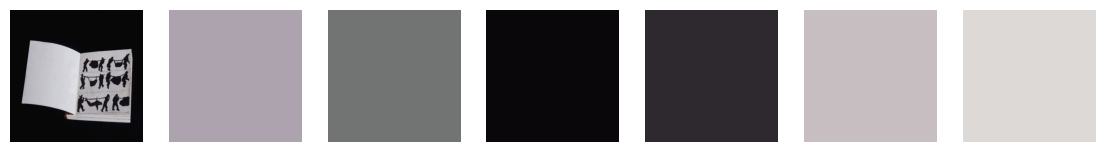

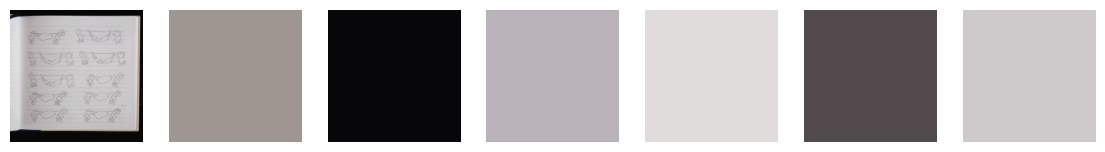

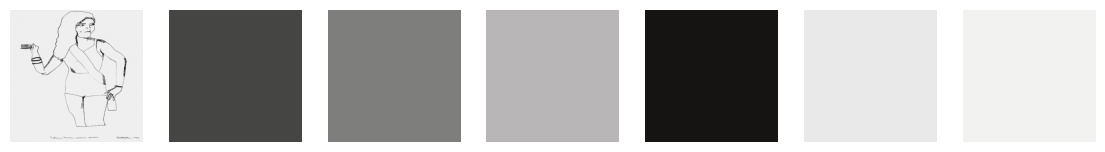

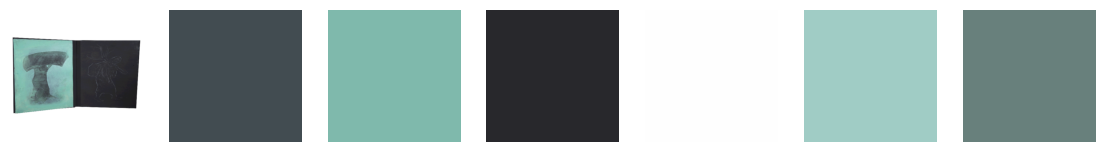

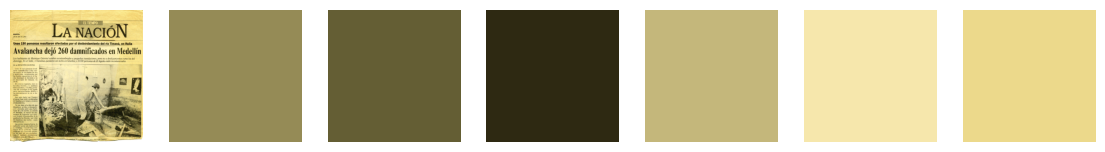

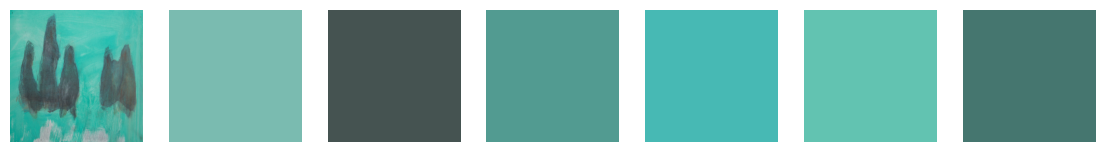

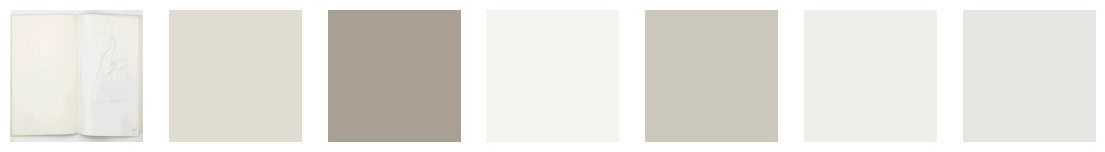

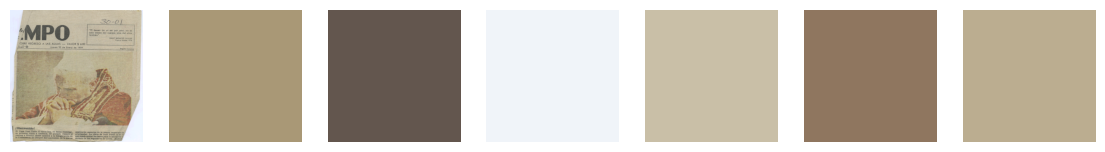

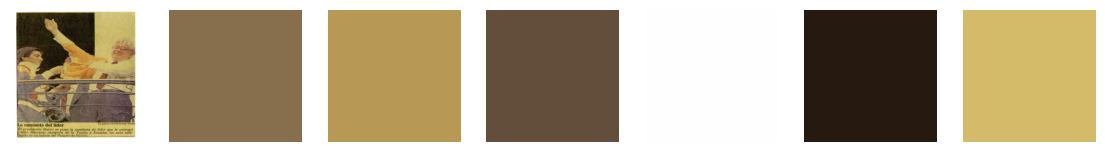

In [14]:
for i, image in enumerate(images[:10]):
    if image is not None:
        img_palette = palettes[i]
        show_palette(img_palette, img=image)

# Entrenando el modelo desde cero

In [15]:
pc = PaletteCreator(method="neural_network", train_epochs=20, train_images = np.array(images), 
                    use_pretrained=False)

Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  7.96batch/s, loss=0.00365]


In [19]:
%%time
palettes, proportions = pc.create_palette(images) # crear paletas

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1238/1238 [04:55<00:00,  4.19it/s]

CPU times: user 5min 38s, sys: 7.82 s, total: 5min 46s
Wall time: 4min 55s


## Guardar resultados

In [20]:
save_results_to_db(db, "neuralnetwork+fromscratch+bitcutting", palettes, proportions)
db.to_csv(PATH_IMAGES_METADATA, index=False)

# Ejemplo de visualización

In [21]:
#db = pd.read_csv(PATH_IMAGES_METADATA)

In [22]:
#palette_img = db['kmeans_palette'].values
#proportions_img = db['kmeans_proportions'].values

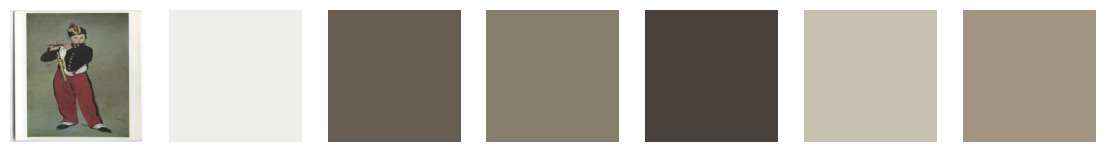

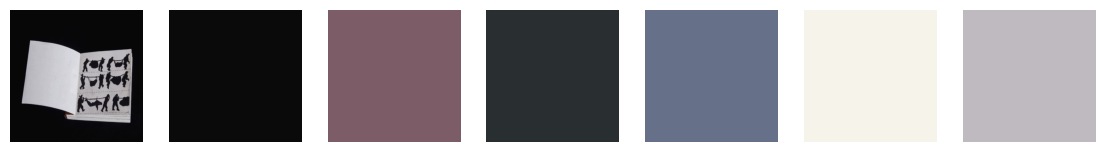

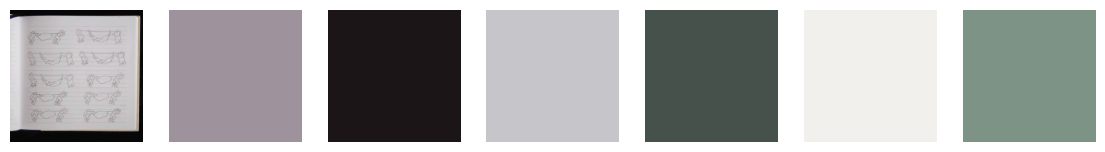

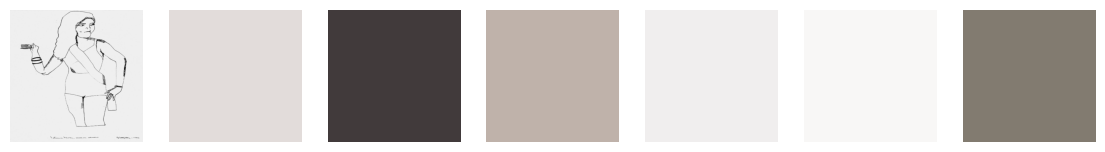

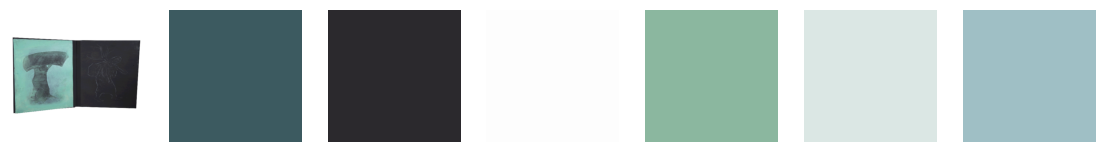

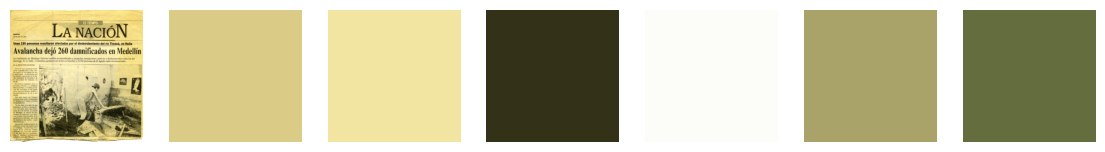

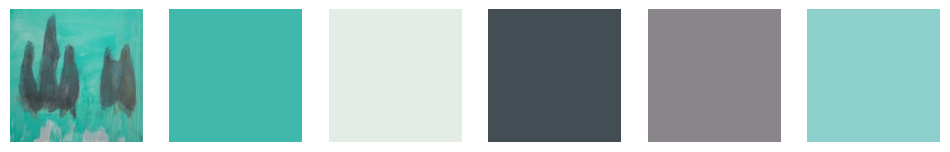

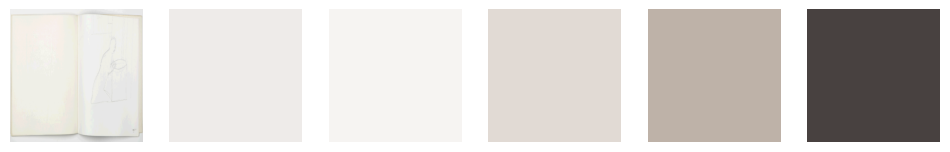

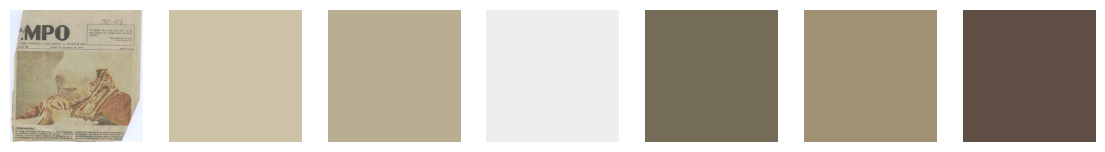

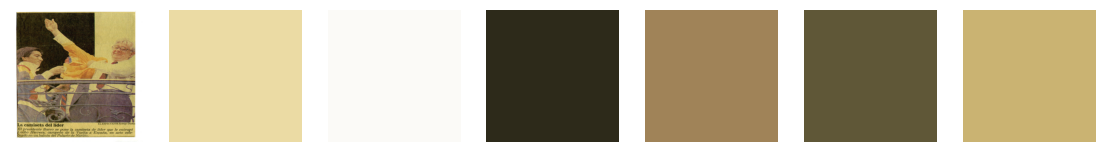

In [23]:
for i, image in enumerate(images[:10]):
    if image is not None:
        img_palette = palettes[i]
        show_palette(img_palette, img=image)

In [24]:
db

,Unnamed: 0,filename,path_image,kmeans_palette,kmeans_proportions,median-cut_palette,median-cut_proportions,kmeans+bitcutting_palette,kmeans+bitcutting_proportions,median-cut+average-filter_palette,...,pnn-mode+resize_palette,pnn-mode+resize_proportions,pnn-mean+resize_palette,pnn-mean+resize_proportions,neuralnetwork+bitcutting_palette,neuralnetwork+bitcutting_proportions,neuralnetwork+train+bitcutting_palette,neuralnetwork+train+bitcutting_proportions,neuralnetwork+fromscratch+bitcutting_palette,neuralnetwork+fromscratch+bitcutting_proportions
0,0,52e95bdbba05837f97424a3580258ffb.jpg,data/beatriz_gonzalez/52e95bdbba05837f97424a35...,"[[121, 126, 105], [235, 235, 233], [102, 105, ...","[0.2937311703360371, 0.26539011201235996, 0.25...","[[86, 74, 62], [110, 115, 98], [236, 236, 235]...","[0.2649957066804053, 0.2499656534432423, 0.241...","[[111, 119, 95], [231, 231, 231], [95, 103, 79...","[0.301753572808034, 0.2723281189648513, 0.1439...","[[86, 82, 71], [114, 102, 86], [236, 236, 234]...",...,"[[107, 108, 89], [222, 224, 225], [93, 95, 80]...","[0.49709401709401707, 0.23247863247863249, 0.1...","[[113, 116, 97], [233, 233, 231], [97, 64, 58]...","[0.49709401709401707, 0.23247863247863249, 0.1...","[[242, 241, 235], [100, 96, 78], [194, 191, 17...","[0.3843269348144531, 0.26114654541015625, 0.16...","[[185, 172, 163], [113, 61, 57], [46, 45, 45],...","[0.28882598876953125, 0.26446533203125, 0.2546...","[[238, 238, 235], [102, 92, 81], [136, 128, 10...","[0.3498039245605469, 0.2613029479980469, 0.232..."
1,1,50d8cae4e67dd4e690d443cab7a88fe9.jpg,data/beatriz_gonzalez/50d8cae4e67dd4e690d443ca...,"[[4, 4, 6], [185, 183, 188], [206, 206, 212], ...","[0.6350989583333333, 0.14283958333333333, 0.10...","[[3, 3, 4], [195, 194, 200], [12, 10, 14], [17...","[0.5190302083333334, 0.23521770833333333, 0.12...","[[7, 7, 7], [191, 183, 191], [175, 167, 175], ...","[0.6063708333333333, 0.128721875, 0.1213552083...","[[3, 3, 4], [195, 194, 200], [160, 157, 161], ...",...,"[[3, 3, 4], [184, 183, 189], [203, 203, 210], ...","[0.5983333333333334, 0.2125, 0.096770833333333...","[[4, 4, 5], [177, 174, 179], [206, 206, 212], ...","[0.5983333333333334, 0.2125, 0.096770833333333...","[[142, 139, 133], [98, 95, 89], [47, 43, 41], ...","[0.6320610046386719, 0.17446136474609375, 0.15...","[[173, 163, 174], [113, 116, 115], [9, 7, 9], ...","[0.6304702758789062, 0.15348052978515625, 0.10...","[[9, 10, 9], [124, 92, 103], [41, 47, 48], [10...","[0.6318092346191406, 0.2996406555175781, 0.035..."
2,2,51e55522af0fcaa36ecfe6417b063512.jpg,data/beatriz_gonzalez/51e55522af0fcaa36ecfe641...,"[[199, 196, 198], [188, 184, 185], [6, 6, 7], ...","[0.39645416666666666, 0.199446875, 0.158172916...","[[201, 198, 200], [185, 180, 180], [4, 4, 5], ...","[0.4843791666666667, 0.253759375, 0.1368614583...","[[199, 191, 199], [207, 207, 207], [7, 7, 7], ...","[0.262128125, 0.21826979166666666, 0.158196875...","[[199, 197, 199], [183, 178, 179], [4, 4, 5], ...",...,"[[200, 198, 200], [5, 5, 5], [175, 169, 171], ...","[0.7205208333333334, 0.13270833333333334, 0.11...","[[194, 191, 192], [4, 4, 5], [167, 160, 159], ...","[0.7205208333333334, 0.13270833333333334, 0.11...","[[158, 152, 139], [21, 21, 21], [195, 190, 179...","[0.3670921325683594, 0.3361320495605469, 0.157...","[[159, 150, 145], [7, 7, 9], [186, 179, 185], ...","[0.4410362243652344, 0.27069854736328125, 0.15...","[[158, 147, 157], [27, 21, 23], [197, 197, 202...","[0.6876754760742188, 0.15570449829101562, 0.11..."
3,3,3337155ae5bbb9da7ff1582e7d88c22f.JPG,data/beatriz_gonzalez/3337155ae5bbb9da7ff1582e...,"[[233, 233, 233], [235, 235, 235], [2, 2, 2], ...","[0.6509738714108894, 0.31586666848020745, 0.01...","[[221, 221, 221], [235, 235, 235], [226, 226, ...","[0.34206666575989625, 0.31586666848020745, 0.1...","[[231, 231, 231], [7, 7, 7], [31, 31, 31], [18...","[0.9664415609145687, 0.01228333854726314, 0.00...","[[225, 225, 225], [232, 232, 232], [230, 230, ...",...,"[[234, 234, 234], [214, 214, 214], [195, 195, ...",